In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from labellines import labelLine, labelLines

In [3]:
# EM Gaussian profile, emparams in the format [scale, center, size]
def em_prfl(r, emparams):
    return emparams[0]*np.exp(-np.power(r - emparams[1],2)/emparams[2])

# right-hand side of ODE from "Axion dark matter, solitons and the cusp–core problem" Appendix A
def f(r, X, emparams):
    f1 = X[1]
    f2 = -2*X[1]/r + 2*X[2]*X[0] - em_prfl(r, emparams)
    f3 = X[3]
    f4 = -2*X[3]/r + np.power(X[0],2)
    return np.array([f1, f2, f3, f4])

# interval of solution and number of steps
ri, rf, dr = 0, 20, 0.01
steps = int((rf - ri)//dr)
rinterv = np.linspace(ri, rf, steps, endpoint=True)

# single step of RK4
def rk4step(r, X, emparams):
    k1 = dr*f(r, X, emparams)
    k2 = dr*f(r + dr/2, X + k1/2, emparams)
    k3 = dr*f(r + dr/2, X + k2/2, emparams)
    k4 = dr*f(r + dr, X + k3, emparams)
    return X + (k1 + 2*k2 + 2*k3 + k4)/6

def rk4(Xbc, emparams):
    # initialize the arrays
    Xs = np.zeros((4, steps))

    # boundary conditions at r = ri
    Xs[..., 0] = Xbc

    # perform RK4
    bpoint = 0
    for step in np.arange(1, steps):
        rnow = rinterv[step]
        Xs[..., step] = rk4step(rnow, Xs[..., step - 1], emparams)
    
        # the breakpoint 'bpoint' occurs when the solution stops converging to zero at r -> infty
        if Xs[..., step][0] > Xs[..., step - 1][0] or Xs[..., step][0] < 0:
            bpoint = step
            return Xs, bpoint

    return Xs, bpoint

# Step of Monte Carlo for shooting method
def mc_step(phi0, bpointold, emparams):
    Xbc_step = np.array([1, 0, phi0, 0])
    Xs_step, bpoint = rk4(Xbc_step, emparams)

    # If the breakpoint happens for higher values of r, keep the new solution (ground state should have breakpoint at infty)
    if bpoint > bpointold:
        return True, bpoint
    elif bpoint <= bpointold:
        return False, bpointold

# Full Monte Carlo
def find_sol(emparams):
    bpoint = 0
    phi0 = np.random.uniform(-1,0)

    nsteps = 5000
    # count avoids the code 'getting stuck' for large periods of time
    count, step_stdev = 0, 1
    for i in np.arange(nsteps):
        phi0old = phi0
        phi0 += np.random.normal(0,step_stdev)

        mcs = mc_step(phi0, bpoint, emparams)
        if mcs[0]:
            bpoint = mcs[1]
        else:
            phi0 = phi0old
            count += 1
            
        if count > 100:
            count = 0
            step_stdev = step_stdev/2

        if bpoint == steps - 1:
            return phi0, bpoint

    return phi0, bpoint

# Asymptotic behavior of phi
def fit_asymp(r, C, gamma):
        return C/r - gamma

def find_gamma(rinterv_loc, Xs):
    # Find gamma from asymptotic behavior of phi
    tail_ini = 10
    r_asymp, phi_asymp = rinterv_loc[-tail_ini:-1], Xs[2].T[-tail_ini:-1]
    popt, pcov = curve_fit(fit_asymp, r_asymp, phi_asymp)
    gamma, gamma_stdev = popt[1], np.sqrt(np.diag(pcov))[1] 
    return gamma, gamma_stdev

def find_bestsol(emparams):
    # run find_sol ntimes times, the 'best solution' will have the largest value of bpoint
    bpoints, phis, ntimes = [], [], 2
    for i in np.arange(ntimes):
        phi, bpoint = find_sol(emparams)
        phis.append(phi)
        bpoints.append(bpoint)

    return phis[bpoints.index(max(bpoints))], np.array(zip(phis, bpoints)) 

In [4]:
# Finding solutions, emparams in the format [scale, center = 0, size = 1]
scales = np.linspace(-5, 10, 16, endpoint=True)
thetas, phis, gammas = [], [], []
for scale in scales:
    emparams = [scale, 0, 20]
    phi0_plt = find_bestsol(emparams)[0]
    Xbc_plt = np.array([1, 0, phi0_plt, 0])
    Xs, bpoint = rk4(Xbc_plt, emparams)
    rinterv_cut, Xs = rinterv[:bpoint], Xs[:, :bpoint]

    thetas.append(np.array(list(zip(rinterv_cut, Xs[0].T))))
    phis.append(np.array(list(zip(rinterv_cut, Xs[2].T))))

    gamma = find_gamma(rinterv_cut, Xs)[0]
    gammas.append(gamma)

KeyboardInterrupt: 

In [15]:
# Save data
# np.savez("bump_s_0_0dot1.npz", phis = phis, thetas = thetas, gammas = gammas)

# Load saved data
data = np.load("bump_s_0_0dot1.npz", allow_pickle=True)
thetas, phis, gammas = data['thetas'], data['phis'], data['gammas']

IndexError: index 12 is out of bounds for axis 0 with size 12

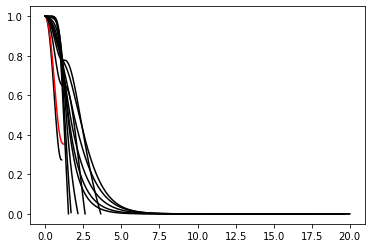

In [16]:
# Plotting the solutions, emparams in the format [scale, center = 0, size = 1]
for i, theta in enumerate(thetas):
    if scales[i] == 0:
        plt.plot(theta.T[0], theta.T[1], color = 'red', label = str(scales[i]))
    else:
        plt.plot(theta.T[0], theta.T[1], color = 'black', label = str(scales[i]))
plt.xlabel("r")
plt.ylabel('Theta')
plt.xlim(left = 0, right = 10);

# xvals = []
# labelLines(plt.gca().get_lines(),  align=False);

Text(0, 0.5, 'Gamma')

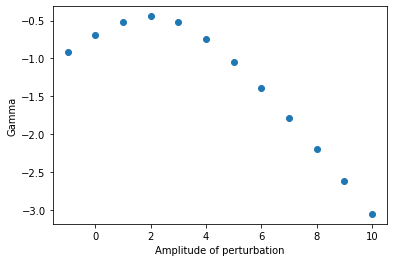

In [14]:
scales = np.linspace(-1, 10, 12, endpoint=True)

plt.scatter(scales,gammas)
plt.xlabel('Amplitude of perturbation')
plt.ylabel('Gamma')

Text(0, 0.5, 'Phi')

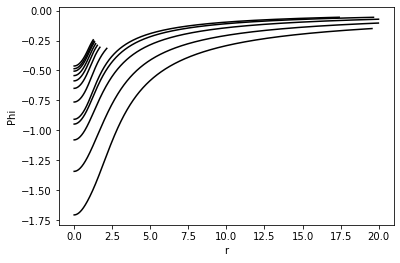

In [38]:
# Plotting the potentials, emparams in the format [scale, center = 0, size = 1]
for i, phi in enumerate(phis):
    plt.plot(phi.T[0], phi.T[1] + gammas[i], color = 'black', label = str(scales[i]))
plt.xlabel("r")
plt.ylabel('Phi')

# xvals = [1,1,1,1]
# labelLines(plt.gca().get_lines(), xvals = xvals, align=False);